<img width="200" src="https://raw.githubusercontent.com/lukwies/mid-bootcamp-project/main/data/img/bikes.png">

# Bikesharing in Seoul / Prediction


### Sources

 * Data: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand
 * Image: https://global.chinadaily.com.cn/a/201801/25/WS5a69cab3a3106e7dcc136a6d.html



In [1]:
import pandas as pd
import numpy as np
import yaml
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#### Load YAML config file

In [2]:
with open('../params.yaml') as file:
    config = yaml.safe_load(file)

#### Load cleaned dataset

In [3]:
df = pd.read_csv(config['data']['csv_cleaned'])

#### Let's drop columns not needed for prediction

In [4]:
df = df.drop(['date', 'daytime', 'seasons',
              'functioning_day', 'temperature_type',
              'solar_radiation'], axis=1)

### Do X/y-split

In [5]:
X = df.drop(['rented_bike_count'], axis=1)
y = df['rented_bike_count']

### Do train/test-split

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X, y,
                                                 test_size=config['testsplit']['test_size'],
                                                 random_state=config['testsplit']['random_state'])

#### Split train/test set into numerical and categorical columns

In [7]:
X_train_num = X_train.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object)

In [8]:
X_test_num = X_test.select_dtypes(np.number)
X_test_cat = X_test.select_dtypes(object)

<br>

### Apply OneHotEncoder on categorical columns

In [9]:
ohe = OneHotEncoder(drop='first')
ohe.fit(X_train_cat)

X_train_cat_enc = ohe.transform(X_train_cat).toarray()
X_test_cat_enc  = ohe.transform(X_test_cat).toarray()

X_train_cat_enc = pd.DataFrame(X_train_cat_enc, columns=ohe.get_feature_names_out(), index=X_train_cat.index)
X_test_cat_enc  = pd.DataFrame(X_test_cat_enc, columns=ohe.get_feature_names_out(), index=X_test_cat.index)

#### Store OneHotEncoder to file

In [10]:
with open(config['encoder']['onehot'], 'wb') as file:
    pickle.dump(ohe, file, pickle.HIGHEST_PROTOCOL)

<br>

### Apply StandardScaler to numerical columns

In [11]:
stdScaler = StandardScaler()
stdScaler.fit(X_train_num)

X_train_num_scaled = stdScaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)

X_test_num_scaled = stdScaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

#### Store StandardScaler to file

In [12]:
with open(config['scaler']['standard'], 'wb') as file:
    pickle.dump(stdScaler, file, pickle.HIGHEST_PROTOCOL)

<br>

### Apply MinMaxScaler to numerical columns

In [13]:
minmax = MinMaxScaler()
minmax.fit(X_train_num_scaled)

X_train_num_scaled = minmax.transform(X_train_num_scaled)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)

X_test_num_scaled = minmax.transform(X_test_num_scaled)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

#### Store MinMaxScaler to file

In [14]:
with open(config['scaler']['minmax'], 'wb') as file:
    pickle.dump(minmax, file, pickle.HIGHEST_PROTOCOL)

#### Build final dataframes

In [15]:
X_train_final = pd.concat([X_train_cat_enc, X_train_num_scaled], axis=1)
X_test_final  = pd.concat([X_test_cat_enc, X_test_num_scaled], axis=1)

In [16]:
X_train_final.head()

,holiday_Yes,month,hour,weekday,temperature,humidity,wind_speed,visibility,rainfall,snowfall
8415,0.0,0.909091,0.652174,0.666667,0.541958,0.622449,0.527027,0.348754,0.0,0.0
5049,0.0,0.454545,0.391304,0.666667,0.711538,0.877551,0.229730,0.256736,0.0,0.0
8395,0.0,0.909091,0.826087,0.500000,0.506993,0.469388,0.189189,0.425013,0.0,0.0
1535,0.0,0.090909,1.000000,0.666667,0.265734,0.704082,0.270270,0.712252,0.0,0.0
5518,0.0,0.545455,0.956522,0.333333,0.786713,0.744898,0.202703,0.494154,0.0,0.0


<br>

### Find the best number of neighbours (k).

In [17]:
def plot_k(X_train, X_test, y_train, y_test, max_k=20):
    '''
    Creates a plot with the r2-score on the y-axis and
    the k-value on th x-axis to determine the best k-value.
    
    Args:
        X_train: Independent variables of the training set
        X_test:  Dependent variables of the training set
        y_train: Independent variables of the test set
        y_test:  Dependent variable of the test set
        max_k:   Maximal k value to exermine
    '''
    
    scores = []
    
    for k in range(2,max_k+1):
        mod = KNeighborsRegressor(n_neighbors=k)
        mod.fit(X_train, y_train)
        score = mod.score(X_test, y_test)
        scores.append(score)
        
    plt.figure(figsize=(5,3))
    plt.plot(range(2, max_k+1), scores, color='blue',
            marker='o', markerfacecolor='red', markersize=10)
    plt.title('R2-score vs. K-value')
    plt.xticks(range(1, max_k+1))
    plt.xlabel('k')
    plt.ylabel('r2')

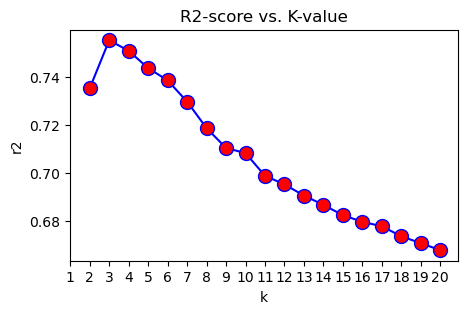

In [18]:
plot_k(X_train_final, X_test_final, y_train, y_test)

##### k=3 gives us the best score

<br>

### Apply KNeighborRegression

In [19]:
n_neighbors = 3
knn = KNeighborsRegressor(n_neighbors, weights='distance')

#### Fit model
Since we have a right skewed distribution on our dependent variable, we calculate y+1 and apply a log transformation.

In [20]:
knn.fit(X_train_final, np.log(y_train+1))

KNeighborsRegressor(n_neighbors=3, weights='distance')

#### Store KNN model to file

In [21]:
with open(config['model']['KNN'], 'wb') as file:
    pickle.dump(knn, file, pickle.HIGHEST_PROTOCOL)

<br>

### Validate model

In [22]:
def get_model_score(y, y_pred):
    '''
    Calculates the r2-score, mse, rmse and mae.
    
    Args:
        y: Dependent variable
        y_pred: Predicted depentend variable
    Return:
        r2-score,mse,rmse,mae
    '''
    r2   = r2_score(y, y_pred)
    mse  = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y, y_pred)
    
    return r2,mse,rmse,mae


def print_model_score(r2, mse, rmse, mae, set_type="train"):
    '''
    Print the score and error metrics.
    '''
    print(f'R2 {set_type}:   {round(r2,4)}')
    print(f'MSE {set_type}:  {round(mse,4)}')
    print(f'RMSE {set_type}: {round(rmse,4)}')
    print(f'MAE {set_type}:  {round(mae,4)}\n')


#### Do the predicting

In [23]:
y_train_pred_log = knn.predict(X_train_final)
y_test_pred_log  = knn.predict(X_test_final)

#### Undo log transformation on y

In [24]:
y_train_pred = np.exp(y_train_pred_log) - 1
y_test_pred  = np.exp(y_test_pred_log) - 1

#### Get training score and error metrics

In [25]:
r2,mse,rmse,mae = get_model_score(y_train, y_train_pred)
print_model_score(r2, mse, rmse, mae, 'train')

R2 train:   1.0
MSE train:  0.0
RMSE train: 0.0
MAE train:  0.0



#### Get testing score and error metrics

In [26]:
r2,mse,rmse,mae = get_model_score(y_test, y_test_pred)
print_model_score(r2, mse, rmse, mae, 'test')

R2 test:   0.7212
MSE test:  116180.9257
RMSE test: 340.8532
MAE test:  186.2729



#### Get residuals

In [27]:
residuals_train = y_train - y_train_pred
residuals_test  = y_test - y_test_pred

<br>

#### Plot regression results

In [28]:
def plot_regression(y, y_pred, set_type="train"):
    '''
    Plot regression.
    
    Args:
        y: Target value
        y_pred: Predicted target value
        set_type: 'train' or 'test'
    '''
    residuals = y - y_pred
    
    fig,ax = plt.subplots(1, 2, figsize=(8,4))

    line = [y.min(), y.max()]
    sx = sns.scatterplot(y=y_pred, x=y, ax=ax[0])
    sx = sns.lineplot(y=line, x=line, color='red', ax=ax[0])
    sx.set(title="Prediction on "+set_type+" set", xlabel='y', ylabel='y-predicted')

    sx = sns.scatterplot(y=y_pred, x=residuals, ax=ax[1])
    sx.set(title="Residuals on "+set_type+" set", xlabel='residuals', ylabel='y-predicted')
    
    plt.tight_layout()
    plt.show()

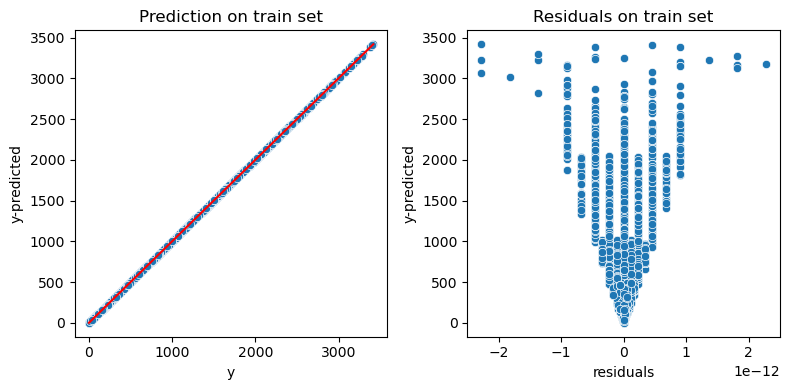

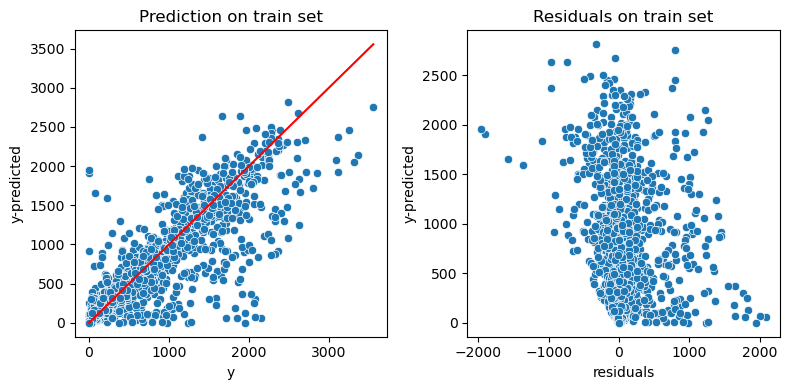

In [29]:
plot_regression(y_train, y_train_pred)
plot_regression(y_test, y_test_pred)

As we can see here, our model is overfitting :-(

#### Let's see how our prediction looks on the temperature

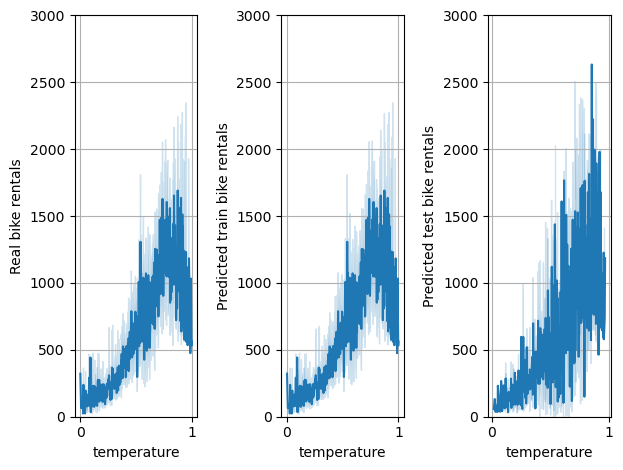

In [30]:
fig,ax = plt.subplots(1,3)

sax = sns.lineplot(data=X_train_final, x='temperature', y=y_train, ax=ax[0])
sax.set(ylabel='Real bike rentals', ylim=(0,3000))
sax.grid()

sax = sns.lineplot(data=X_train_final, x='temperature', y=y_train_pred, ax=ax[1])
sax.set(ylabel='Predicted train bike rentals', ylim=(0,3000))
sax.grid()

sax = sns.lineplot(data=X_test_final, x='temperature', y=y_test_pred, ax=ax[2])
sax.set(ylabel='Predicted test bike rentals', ylim=(0,3000))
sax.grid()

plt.tight_layout()
plt.savefig('../plots/predict_temperature.png', dpi=300)
plt.show()

#### Let's see how our prediction looks on the hour of day

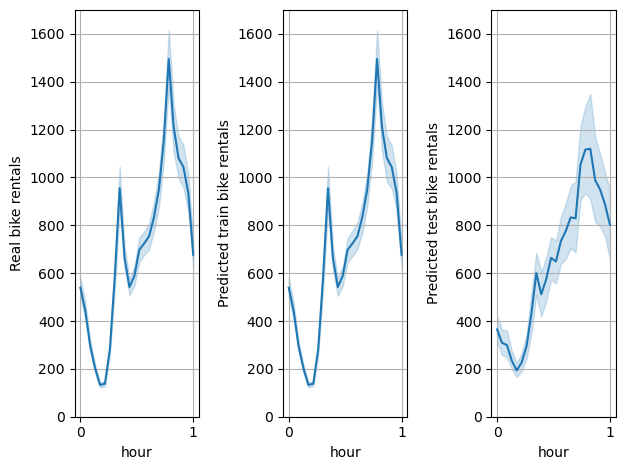

In [31]:
fig,ax = plt.subplots(1,3)

sax = sns.lineplot(data=X_train_final, x='hour', y=y_train, ax=ax[0])
sax.set(ylabel='Real bike rentals', ylim=(0,1700))
sax.grid()

sax = sns.lineplot(data=X_train_final, x='hour', y=y_train_pred, ax=ax[1])
sax.set(ylabel='Predicted train bike rentals', ylim=(0,1700))
sax.grid()

sax = sns.lineplot(data=X_test_final, x='hour', y=y_test_pred, ax=ax[2])
sax.set(ylabel='Predicted test bike rentals', ylim=(0,1700))
sax.grid()

plt.tight_layout()
plt.savefig('../plots/predict_hour.png', dpi=300)
plt.show()